## SOMMAIRE :
-régression logistique   
-linear svm  
-KNNeighbors  
-schéma et ROC de Decision Tree  
-ROC de Random Forest

# CLASSIFICATION MULTI-CLASSES

In [1]:
#Chargement des données après split
import pandas as pd
pd.set_option('display.max_columns', None)
X_train = pd.read_csv("X_train_enc_st.csv", index_col=0, low_memory=False)
X_test = pd.read_csv("X_test_enc_st.csv",index_col=0, low_memory = False)
y_train = pd.read_csv("y_train_reg.csv",index_col=0, low_memory = False)
y_test = pd.read_csv("y_test_reg.csv",index_col=0, low_memory = False)

In [2]:
#Réindexer y_train et y_test
y_train = y_train.reset_index(drop = True)
y_test = y_test.reset_index(drop=True)

#### DISCRETISATION DE LA VARIABLE CIBLE (pour les modèles de classification)


Modélisation en prenant les quartiles de la variable cible après suppression des outliers :  
==> 25% < 210s  
==> 50% < 296s  
==> 75% < 376s    
==> 100% < 779s

Choix de l'équipe :  
**ajuster les quartiles** à la minute arrondie,  
==> **classe 0** : <= 240s (4 min)  
==> **classe 1** : > 240s & <= 300 (5 min)  
==> **classe 2** : > 300s & <= 390 (6 min 30)  
==> **classe 3** : >= 390s & < 780 (13 min)

In [4]:
#Discrétisation de la variable cible dans le jeu d'entraînement
y_train["FirstPumpArriving_AttendanceTime"] = pd.cut(y_train["FirstPumpArriving_AttendanceTime"],
      bins=[0, 240, 300, 390, y_train["FirstPumpArriving_AttendanceTime"].max()],
      labels = [0,1,2,3])

In [5]:
#Discrétisation de la variable cible dans le jeu test
y_test["FirstPumpArriving_AttendanceTime"] = pd.cut(y_test["FirstPumpArriving_AttendanceTime"],
                                                   bins = [0,240,300,390, y_test["FirstPumpArriving_AttendanceTime"].max()],
                                                   labels = [0,1,2,3])

#### PROPORTION DES CLASSES

In [6]:
#Calcul du % représentée par chaque classe
y_test.value_counts()*100/y_test.shape[0]
#==> != de 25% car l'équipe a choisi d'arrondir à la valeur supérieur en minutes.

FirstPumpArriving_AttendanceTime
0                                   28.657237
2                                   26.426164
1                                   23.201341
3                                   21.715257
Name: count, dtype: float64

## REGRESSION LOGISTIQUE

#### INSTANCIATION

In [7]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter = 1000)

#### ENTRAINEMENT SUR LE JEU TRAIN

In [8]:
#Conversion de y_train en array pour appliquer la fonction "fit"
y_train = y_train.values.ravel()

In [9]:
#Application sur le jeu d'entraînement
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

#### PREDICTIONS

In [10]:
#Prédire les données sur le jeu test
y_pred = clf.predict(X_test)

In [11]:
#Conversion de y_pred en array de 2D à un array à 1D pour appliquer la fonction "predict"
y_test = y_test.values.ravel()

In [12]:
#Afficher la matrice de confusion
cm = pd.crosstab(y_test, y_pred, rownames = ["valeurs réelles"], colnames = ["valeurs prédites"])
cm

valeurs prédites,0,1,2,3
valeurs réelles,,,,
0,59005,149,20588,8616
1,43267,113,20872,7284
2,43466,117,27330,10566
3,31179,78,23158,12539


In [13]:
#Afficher les prédictions en probabilités
probs = clf.predict_proba(X_test)
probs = pd.DataFrame(probs)

#### SCORES

In [14]:
#Calculer le score Accuracy (pour les modèles de classification)
score_train = clf.score(X_train, y_train)
score_test = clf.score(X_test, y_test)
print("Accuracy sur le jeu d'entraînement :", score_train,"\nAccuracy sur le jeu test :", score_test)
print("Il n'y a pas d'overfitting apparent")

Accuracy sur le jeu d'entraînement : 0.3217606631920007 
Accuracy sur le jeu test : 0.3210455133673016
Il n'y a pas d'overfitting apparent


In [15]:
#Afficher le rapport de classification
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.67      0.44     88358
           1       0.25      0.00      0.00     71536
           2       0.30      0.34      0.32     81479
           3       0.32      0.19      0.24     66954

    accuracy                           0.32    308327
   macro avg       0.30      0.30      0.25    308327
weighted avg       0.30      0.32      0.26    308327



#### COURBE ROC

In [16]:
#Binarisation (One-vs-All) des labels pour tracer les courbes ROC
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes = [0,1,2,3])
#y_test_bin

In [19]:
import numpy as np
y_test_bin = np.array(y_test_bin)
probs = np.array(probs)

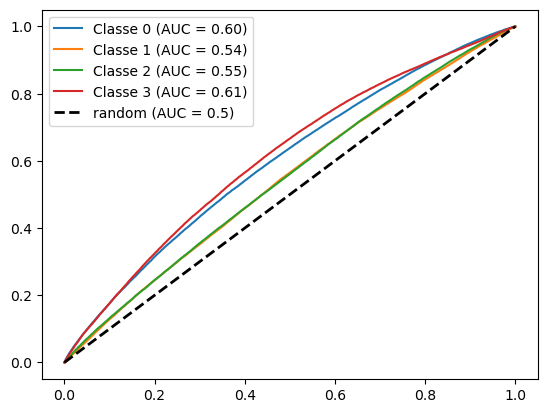

In [20]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
for i in range(4) :
    fpr, tpr, threshold = roc_curve(y_test_bin[:,i], probs[:,i])
    ##Calculer l'aire sous la courbe
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Classe {i} (AUC = {roc_auc:.2f})')
##Ligne de hasard
plt.plot([0,1],[0,1], color = 'black', linestyle = '--', linewidth = 2, label = "random (AUC = 0.5)")
plt.legend()
plt.show()

## LINEAR SVM

#### INSTANCIATION

In [21]:
from sklearn.svm import LinearSVC
svm = LinearSVC(dual = False, max_iter = 5000)

In [22]:
#Entraîner le modèle sur le jeu d'entraînement
svm.fit(X_train, y_train)

LinearSVC(dual=False, max_iter=5000)

#### PREDICTIONS

In [24]:
#Afficher les prédictions obtenues 
y_pred = svm.predict(X_test)

In [25]:
#Conversion du format de y_train en 1D
y_test = y_test.ravel()

In [26]:
#Afficher la matrice de confusion
cm = pd.crosstab(y_test,y_pred, rownames = ["classe réelle"], colnames = ["classe prédite"])
cm

classe prédite,0,1,2,3
classe réelle,,,,
0,58222,48,20197,9891
1,41992,52,20449,9043
2,40014,42,27829,13594
3,27210,29,23426,16289


#### SCORES

In [27]:
#Evaluer le modèle avec l'accuracy
score_train = svm.score(X_train, y_train)
score_test = svm.score(X_test, y_test)
print("Accuracy sur le jeu d'entraînement :", score_train)
print("Accuracy sur le jeu test :", score_test)
print("Il n'y a pas d'overfitting")

Accuracy sur le jeu d'entraînement : 0.33250737042166273
Accuracy sur le jeu test : 0.33208898344938975
Il n'y a pas d'overfitting


In [28]:
#Afficher le rapport de classification
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.66      0.46     88358
           1       0.30      0.00      0.00     71536
           2       0.30      0.34      0.32     81479
           3       0.33      0.24      0.28     66954

    accuracy                           0.33    308327
   macro avg       0.32      0.31      0.26    308327
weighted avg       0.32      0.33      0.28    308327



## KNN CLASSIFIER

#### INSTANCIATION

In [29]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()

In [30]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [31]:
X_train_small = X_train.sample(n=10000, random_state=42)  
y_train_small = y_train.sample(n=10000, random_state=42)
#X_test_small =  X_test.sample(n=10000, random_state = 42)
#y_test_small =  y_test.sample(n=10000, random_state = 42)

#### GRIDSEARCHCV

In [32]:
#Convertir y_train_small en 1D
y_train_small = y_train_small.values.ravel()

In [33]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': [10, 15]}  # Limiter la recherche à quelques valeurs
knc = KNeighborsClassifier(metric = 'minkowski')
grid_knc = GridSearchCV(estimator=knc, param_grid=parameters, cv=3)  # Validation croisée à 3 plis
grid_knc.fit(X_train_small, y_train_small)

# Résultats de GridSearch : obtenir les meilleurs paramètres et résultats
best_params = grid_knc.best_params_  # Meilleur n_neighbors
best_score = grid_knc.best_score_    # Meilleur score moye

#### PREDICTIONS

In [34]:
#Afficher les prédictions obtenues par le modèle
y_pred = grid_knc.predict(X_test)

In [35]:
#Afficher les prédictions en probabilités
probs = grid_knc.predict_proba(X_test)

In [36]:
#Convertir y_train_small en 1D
y_test = y_test.values.ravel()

In [37]:
#Afficher la matrice de confusion
cm = pd.crosstab(y_test, y_pred, rownames = ["classe réelle"], colnames = ["classe prédite"])
cm

classe prédite,0,1,2,3
classe réelle,,,,
0,40189,17642,18008,12519
1,30531,14804,15755,10446
2,32570,16526,18915,13468
3,25497,12699,15134,13624


#### SCORES

In [38]:
#Accuracy :
score_train = grid_knc.score(X_train_small, y_train_small)
score_test = grid_knc.score(X_test, y_test)
print("Accuracy sur le jeu d'entraînement :", score_train)
print("Accuracy sur le jeu test:", score_test)
print("Accuracy sur le jeu d'entraînement est supérieur au jeu test, il y un overfitting apparent")

Accuracy sur le jeu d'entraînement : 0.405
Accuracy sur le jeu test: 0.28389339889143667
Accuracy sur le jeu d'entraînement est supérieur au jeu test, il y un overfitting apparent


In [39]:
#Rapport de classification
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.31      0.45      0.37     88358
           1       0.24      0.21      0.22     71536
           2       0.28      0.23      0.25     81479
           3       0.27      0.20      0.23     66954

    accuracy                           0.28    308327
   macro avg       0.28      0.27      0.27    308327
weighted avg       0.28      0.28      0.28    308327



#### COURBES ROC

In [40]:
#Binarisation (One-vs-All) des labels pour tracer les courbes ROC
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes = [0,1,2,3])
#y_test_bin

In [41]:
#Prédiction en probabilité
probs = grid_knc.predict_proba(X_test)

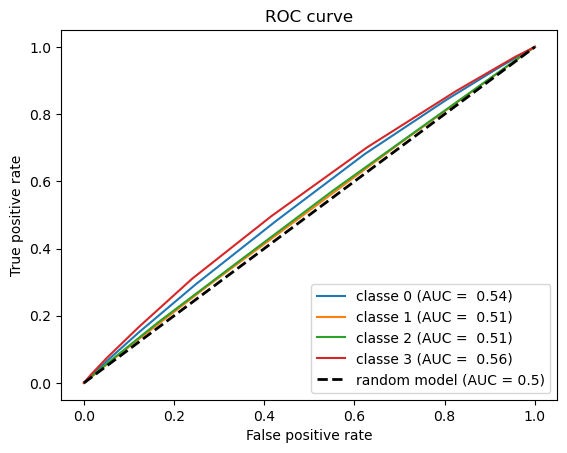

In [42]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
for i in range(4) :
    fpr, tpr, threshold = roc_curve(y_test_bin[:,i], probs[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'classe {i} (AUC = {roc_auc : .2})')
plt.plot([0,1],[0,1], color = 'black', linestyle = '--', linewidth = 2, label = "random model (AUC = 0.5)")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc = 'lower right')
plt.title("ROC curve")
plt.show()

## DECISION TREE CLASSIFIER

#### INSTANCIATION

In [43]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

#### FIT

In [44]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### PREDICTION

In [45]:
#Calculer les prédictions 
y_pred = clf.predict(X_test)

#### REPRESENTATION GRAPHIQUE

In [61]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize =(100,100))
plot_tree(clf_min_samples,feature_names = ["Easting_rounded","Northing_rounded","DeployedFromStation_Name","Meteo_encoded","Visibility_encoded","StopCodeDescription_Chimney Fire","StopCodeDescription_False alarm - Good intent","StopCodeDescription_False alarm - Malicious","StopCodeDescription_Late Call","StopCodeDescription_Primary Fire","StopCodeDescription_Secondary Fire","StopCodeDescription_Special Service","StopCodeDescription_Use of Special Operations Room","PropertyCategory_Boat","PropertyCategory_Dwelling","PropertyCategory_Non Residential","PropertyCategory_Other Residential","PropertyCategory_Outdoor","PropertyCategory_Outdoor Structure","PropertyCategory_Rail Vehicle","PropertyCategory_Road Vehicle","Hour","Year"],
         class_names = ["0","1","2","3"],filled = True)
plt.show()

In [67]:
#Binarisation (One-vs-All) des labels pour tracer les courbes ROC
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes = [0,1,2,3])
y_test_bin

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

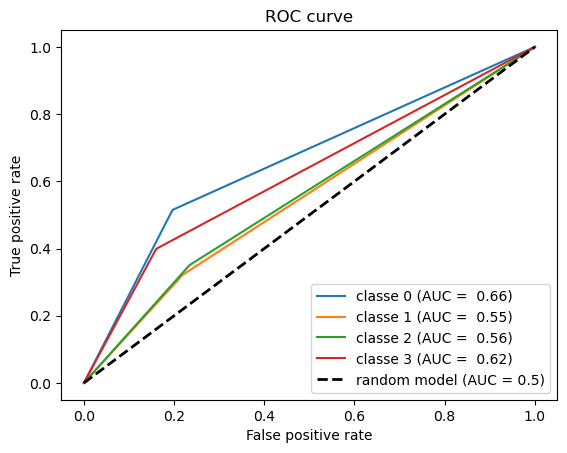

In [68]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
for i in range(4) :
    fpr, tpr, threshold = roc_curve(y_test_bin[:,i], probs[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'classe {i} (AUC = {roc_auc : .2})')
plt.plot([0,1],[0,1], color = 'black', linestyle = '--', linewidth = 2, label = "random model (AUC = 0.5)")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc = 'lower right')
plt.title("ROC curve")
plt.show()

## RANDOM FOREST CLASSIFIER

#### INSTANCIATION

In [59]:
#Instancier
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_jobs = -1,
                               random_state = 42)

In [61]:
#Conversion de y_train en 1D
y_train = y_train.ravel()

#### FIT

In [62]:
#Fit
rf_clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

#### IMPORTANCE

In [138]:
#Créer un dictionnaire pour stocker les variables explicatives et leur importance
features = {}
for col, importance in zip(X_train.columns,rf_clf.feature_importances_):
    features[col] = importance

In [139]:
#Convertir le dictionnaire en dataframe
importance_df = pd.DataFrame.from_dict(features, orient= 'index')
importance_df

,0
Easting_rounded,2.411922e-01
Northing_rounded,2.348672e-01
DeployedFromStation_Name,1.328454e-01
Meteo_encoded,7.269521e-02
Visibility_encoded,7.441744e-04
StopCodeDescription_Chimney Fire,1.639428e-04
StopCodeDescription_False alarm - Good intent,6.117298e-03
StopCodeDescription_False alarm - Malicious,2.706723e-03
StopCodeDescription_Late Call,7.282676e-05
StopCodeDescription_Primary Fire,6.892692e-03


In [140]:
#Renommer la colonne 0
importance_df = importance_df.rename({0:"importance"}, axis=1)
importance_df

,importance
Easting_rounded,2.411922e-01
Northing_rounded,2.348672e-01
DeployedFromStation_Name,1.328454e-01
Meteo_encoded,7.269521e-02
Visibility_encoded,7.441744e-04
StopCodeDescription_Chimney Fire,1.639428e-04
StopCodeDescription_False alarm - Good intent,6.117298e-03
StopCodeDescription_False alarm - Malicious,2.706723e-03
StopCodeDescription_Late Call,7.282676e-05
StopCodeDescription_Primary Fire,6.892692e-03


In [141]:
#Trier l'importance des variables
importance_sorted = importance_df.sort_values(by="importance", ascending= False)
importance_sorted

,importance
Easting_rounded,2.411922e-01
Northing_rounded,2.348672e-01
Hour,1.481579e-01
DeployedFromStation_Name,1.328454e-01
Year,1.327682e-01
Meteo_encoded,7.269521e-02
StopCodeDescription_Primary Fire,6.892692e-03
StopCodeDescription_False alarm - Good intent,6.117298e-03
StopCodeDescription_Special Service,5.512619e-03
PropertyCategory_Dwelling,3.118105e-03


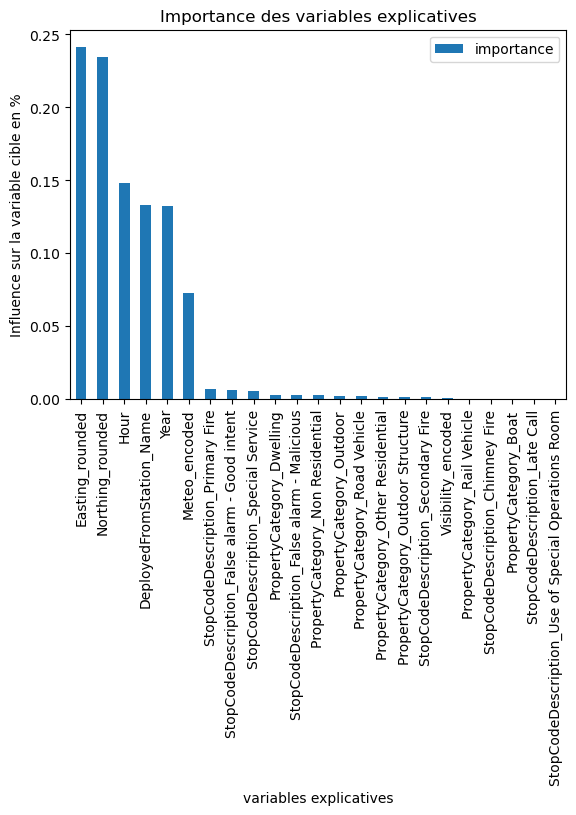

In [142]:
#Représentation graphique
import seaborn as sns
importance_sorted.plot.bar()
plt.title("Importance des variables explicatives")
plt.xlabel("variables explicatives")
plt.ylabel("Influence sur la variable cible en %")
plt.show()

In [143]:
#Binarisation (One-vs-All) des labels pour tracer les courbes ROC
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes = [0,1,2,3])
y_test_bin

array([[0, 1, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0]])

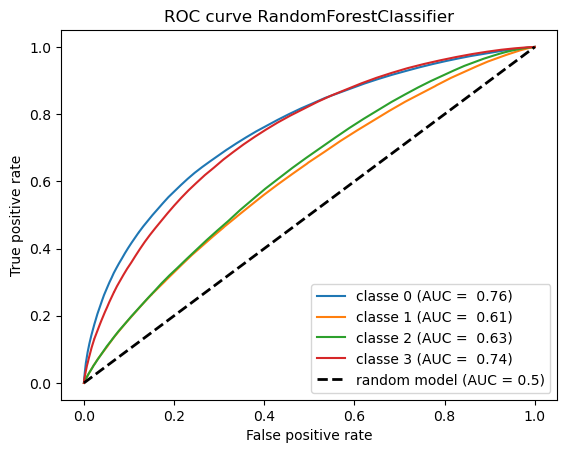

In [144]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
for i in range(4) :
    fpr, tpr, threshold = roc_curve(y_test_bin[:,i], probs[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label = f'classe {i} (AUC = {roc_auc : .2})')
plt.plot([0,1],[0,1], color = 'black', linestyle = '--', linewidth = 2, label = "random model (AUC = 0.5)")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.legend(loc = 'lower right')
plt.title("ROC curve RandomForestClassifier")
plt.show()